## Image Desnoise

## Import  libraries

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)




An autoencoder can also be trained to remove noise from images. 1) create a noisy version of the Fashion MNIST dataset by applying random noise to each image. 2) train an autoencoder using the noisy image as input, and the original image as the target.



In [11]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [13]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


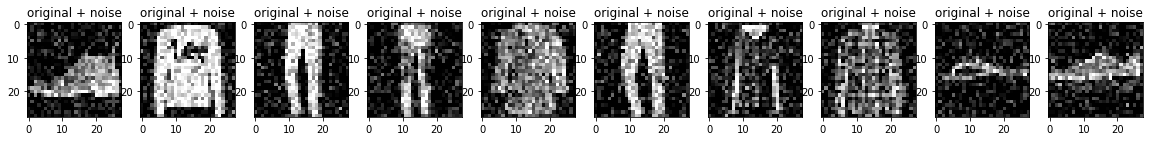

In [14]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D] layers in the `encoder`, and [Conv2DTranspose] layers in the `decoder`.

In [15]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [16]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [17]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0164 - val_loss: 0.0095
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.006

 images are downsampled from 28x28 to 7x7.

In [18]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [19]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [20]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

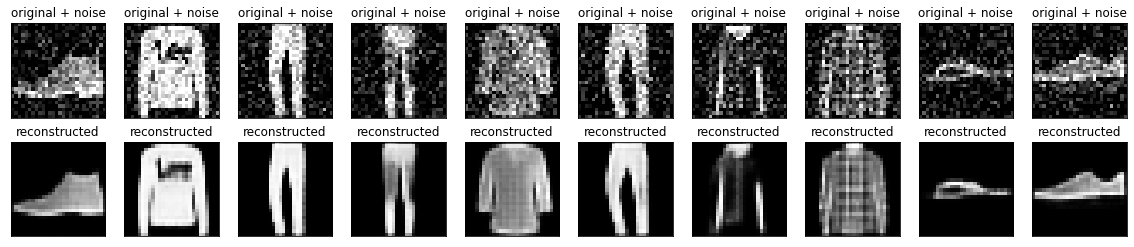

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()